In [350]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from nilearn.connectome import ConnectivityMeasure
from matplotlib import cm
from matplotlib.colors import Normalize

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature


# Load behavioral data

In [351]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study'] = 'bochum'
df_essen['study'] = 'essen'
df_szeged['study'] = 'szeged'
df = pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df = df.reset_index()
df

,index,Unnamed: 0,ID,Excluded,exclusion_crit,Male,day_menses,Age,height,weight,...,weight..kg.,psq_moderate,psq_minor,PSQ20,PSQI,MDT_log_geom,Pulse_MRI,Pulse_QST,BDI,PSQ20_essen
0,0,0,4,0.0,NaN,1.0,NaN,25.552361,175.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,6,0.0,NaN,1.0,NaN,33.453799,183.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,7,0.0,NaN,1.0,NaN,26.119097,186.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,8,0.0,NaN,1.0,NaN,25.445585,180.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,9,0.0,NaN,0.0,6.0,22.573580,176.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,14,14,22,0.0,NaN,1.0,NaN,24.000000,185.0,82.0,...,NaN,27.0,11.0,6.0,1.0,-1.259900,73.0,76.0,5.0,24.0
87,15,15,24,0.0,NaN,1.0,NaN,22.000000,183.0,83.0,...,NaN,28.0,16.0,9.0,1.0,-1.913513,85.0,86.0,0.0,25.0
88,16,16,25,0.0,NaN,1.0,NaN,22.000000,195.0,77.0,...,NaN,20.0,9.0,11.0,NaN,-1.581106,88.0,91.0,1.0,25.0
89,17,17,28,0.0,NaN,0.0,5.0,23.000000,162.0,59.0,...,NaN,34.0,18.0,43.0,2.0,-1.145363,78.0,89.0,7.0,37.0


# Compute connectivity

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

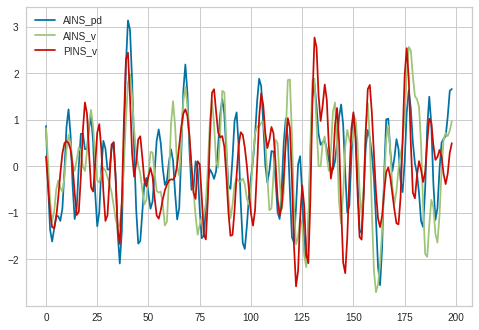

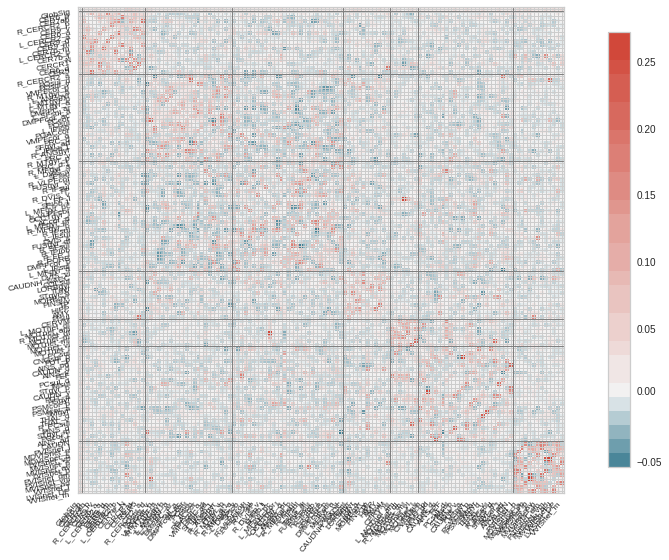

In [352]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'

    ts = pd.read_csv(f_scrub).iloc[:, 1:]  # here we can omit global signal...

    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd

    perc_scrubbed.append(100 - 100 * len(ts.shape) / len(fd))
    timeseries.append(ts.values)

# double check visually
sub_idx = 10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()
## Load region and module names for the MIST122 atlas
labels = ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules = np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)
## Calculate functional connectivity as partial correlation
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=False)
X = correlation_measure.fit_transform(timeseries)  # these are the features
joblib.dump(X, "../res/multi-center/all_features.joblib")

# double-check the mean matrix visually
mat = correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0  # zero diag
plot.plot_matrix(mat, labels, modules)

In [353]:
X.shape

(91, 123, 123)

# Load participant-level connectivity data

In [354]:
mc_model = pd.read_csv('../res/multi-center/finalized_model_connections.csv')
mc_model = mc_model[mc_model['abs_multi-center']>0.02]
conns_mc_model = np.zeros((X.shape[0], len(mc_model)))
for idx, (i_a, i_b) in enumerate(zip(mc_model.idx_A, mc_model.idx_B)):
    conns_mc_model[:, idx] = X[:, i_a, i_b]
    #if mc_model.iloc[idx,:]['multi-center'] < 0:
    #    conns_mc_model[:, idx] *= -1
conns_mc_model = pd.DataFrame(conns_mc_model, columns=mc_model.connectivity)
conns_mc_model


connectivity,GlobSig - VMPFcor_p,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,L_CERCR2_a - R_MTgyr_a,CER7b_m - PCcor.1,CER7b_l - R_PORB,CER6_d - OCCTgyr_l,CER6_d - MOTnet_m,...,R_IPlob - STgyr_p,L_MFgyr_a - LORBgyr,CAUDNH_NACC - MOTnet_vl,COLsul - MOTnet_vl,TP - CAUDN,MOTnet_m - LVISnet_p,AINS_v - MVISnet_ad,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
0,0.021891,0.127759,-0.021352,0.145841,-0.064799,-0.048813,-0.042026,0.000000,-0.079679,-0.100725,...,-0.065551,-0.012065,0.054709,-0.096509,0.119536,-0.046985,0.112617,-0.018719,-0.074869,-0.006091
1,0.015723,0.094542,0.125166,0.201690,-0.074666,-0.122995,0.091628,0.000000,-0.016422,0.012459,...,-0.005558,0.067681,0.077508,0.010236,-0.020578,0.023110,0.137049,-0.016450,-0.015471,0.032730
2,0.013114,-0.090155,0.052071,0.068738,0.030321,-0.032115,-0.196758,0.124899,0.121946,-0.059550,...,0.044654,-0.003242,0.011217,-0.023302,0.027970,-0.017286,0.104354,0.069925,0.113806,-0.111940
3,0.020028,-0.031791,0.147238,0.190687,0.042861,-0.048255,0.030311,0.000386,0.081606,0.036209,...,-0.003451,0.033829,-0.082446,-0.008410,0.189698,0.066444,-0.022866,0.053899,-0.073163,0.060156
4,0.027947,-0.003799,0.133163,0.153021,-0.029537,-0.038915,0.017608,0.087969,0.030264,-0.045649,...,-0.030480,-0.038245,-0.159668,-0.042111,0.041197,0.021621,-0.010212,-0.039720,-0.019237,0.064941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.031210,0.011089,0.026238,0.210191,-0.017681,-0.078204,-0.048726,-0.013898,0.014368,-0.004617,...,0.010992,0.045305,0.025894,0.027661,-0.036706,0.020761,0.040750,-0.016146,-0.020249,0.095300
87,0.021306,0.037766,0.173000,0.157848,-0.082971,0.017431,-0.028058,0.009052,0.032332,0.055295,...,-0.047451,0.077870,-0.138718,-0.031196,-0.071744,-0.047688,0.042326,0.023084,0.100832,-0.052292
88,0.014579,-0.108385,0.099388,0.053617,0.046721,-0.120663,-0.066575,0.071326,0.013218,0.054301,...,0.014420,-0.199809,-0.006506,0.032511,-0.067470,-0.020835,-0.049692,0.069901,0.094161,-0.025747
89,0.019275,-0.146022,0.036162,0.247881,0.005831,0.169983,0.146273,-0.056621,0.023395,0.030448,...,-0.020894,0.014597,-0.046275,-0.092783,-0.076256,-0.016585,-0.005255,-0.075313,0.036747,-0.094788


In [355]:
#vars = df[['Male', 'Age', 'CDT_log_mean', 'WDT_log_mean', 'MDT_log_geom', 'CPT', 'HPT', 'MPT_log_geom', 't50', 'psq', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'anx_state', 'anx_trait', 'PSQ20', 'ads_k', 'Glx_mean', 'GABA_mean', 'meanFD', 'maxFD', 'medianFD', 'BP_MRI_sys', 'BP_MRI_dias', 'BP_QST_sys', 'BP_QST_dias' ]]

df2 = df.copy()
df2['nHPT'] = df.HPT * -1
df2['nMPT'] = df.MPT_log_geom * -1
df2['nt50'] = df.t50 * -1
df2['npsq'] = df.psq * -1
df2['nanx_state'] = df.anx_state * -1
df2['nanx_trait'] = df.anx_trait * -1
df2['study'] = df.study.astype('category').cat.codes

#vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'pcs_catastrophizing', 'pcs_rumination']]
vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'nanx_state', 'nanx_trait', 'PSQ20', 'PSQI', 'ads_k', 'pcs_catastrophizing']]
#vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'nanx_state', 'nanx_trait', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'PSQ20', 'ads_k']]

vars.corrwith(df.mean_QST_pain_sensitivity)

CPT                    0.714782
nHPT                   0.769679
nMPT                   0.634185
nt50                   0.534950
npsq                   0.190144
nanx_state             0.202458
nanx_trait             0.204718
PSQ20                  0.308412
PSQI                   0.296726
ads_k                  0.081807
pcs_catastrophizing    0.134912
dtype: float64

In [356]:
corrmtx = np.zeros((vars.shape[1], conns_mc_model.shape[1]))

for i in range(vars.shape[1]):
    for j in range(conns_mc_model.shape[1]):
        mask = ~np.isnan(vars.values[:,i]) & ~np.isnan(conns_mc_model.values[:,j])
        corrmtx[i, j] = np.corrcoef(vars.values[mask,i], conns_mc_model.values[mask,j])[0,1]
corrmtx = pd.DataFrame(corrmtx, columns=conns_mc_model.columns, index=vars.columns)
corrmtx

connectivity,GlobSig - VMPFcor_p,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,L_CERCR2_a - R_MTgyr_a,CER7b_m - PCcor.1,CER7b_l - R_PORB,CER6_d - OCCTgyr_l,CER6_d - MOTnet_m,...,R_IPlob - STgyr_p,L_MFgyr_a - LORBgyr,CAUDNH_NACC - MOTnet_vl,COLsul - MOTnet_vl,TP - CAUDN,MOTnet_m - LVISnet_p,AINS_v - MVISnet_ad,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
CPT,0.218888,-0.231473,0.310017,0.181493,-0.136003,-0.088551,0.269774,-0.010553,-0.202779,-0.193640,...,-0.183506,0.305101,0.069552,-0.252543,-0.221531,0.174136,-0.219074,0.066448,0.176775,0.138239
nHPT,0.161564,-0.254461,0.347498,0.252683,-0.232522,-0.113355,0.167964,-0.120982,-0.027950,-0.172492,...,-0.221293,0.153008,0.137473,-0.112379,-0.215045,0.298346,-0.228620,0.283450,0.274513,0.187179
nMPT,0.301945,-0.201422,0.027588,0.164708,-0.118144,-0.064367,0.219451,-0.343802,-0.197468,-0.327756,...,-0.220520,0.169292,0.233771,-0.235179,-0.156909,0.439023,-0.171467,0.092689,0.348656,0.248983
nt50,0.009989,-0.319194,0.069174,0.084996,0.015976,-0.007896,0.255984,-0.172967,-0.217371,-0.047768,...,-0.167443,0.233145,0.018380,-0.464875,-0.315519,0.408920,-0.324741,-0.082198,0.286457,0.286114
npsq,0.361906,-0.009865,0.077909,0.375797,0.105488,0.109571,-0.059947,-0.005772,-0.212751,-0.274854,...,-0.025163,0.035462,-0.180290,-0.063695,-0.155950,0.282711,-0.083695,0.003573,0.051586,-0.010707
nanx_state,0.394896,-0.026690,0.001207,0.431048,0.144962,0.055982,-0.149586,-0.039920,-0.162293,-0.263870,...,-0.008040,0.073469,-0.158115,-0.016677,-0.118566,0.260548,-0.179421,-0.046450,0.139687,-0.035873
nanx_trait,0.385377,-0.042216,0.007472,0.413689,0.153239,0.048025,-0.143312,-0.083242,-0.165041,-0.263757,...,0.015895,0.053506,-0.146116,-0.010835,-0.145490,0.278432,-0.172157,-0.013330,0.160756,-0.021476
PSQ20,0.082060,-0.143464,-0.014080,0.320610,0.028630,0.272167,0.307483,-0.098661,-0.129273,-0.283738,...,-0.176648,0.094205,0.038987,-0.200759,-0.118110,0.301214,-0.203073,-0.046487,0.135216,-0.040917
PSQI,-0.080914,-0.190889,-0.033573,0.221576,-0.027921,-0.037023,-0.091958,-0.052302,-0.160002,-0.209217,...,0.132302,0.157766,-0.046018,-0.006381,0.079150,0.352548,-0.025996,0.013938,0.147407,0.015165
ads_k,0.079481,-0.087482,0.014304,0.210167,0.063446,0.025343,0.026394,0.079938,-0.040126,-0.086669,...,-0.023842,0.149938,-0.131829,-0.011029,0.153293,0.118497,-0.000716,-0.056921,-0.031748,0.044036


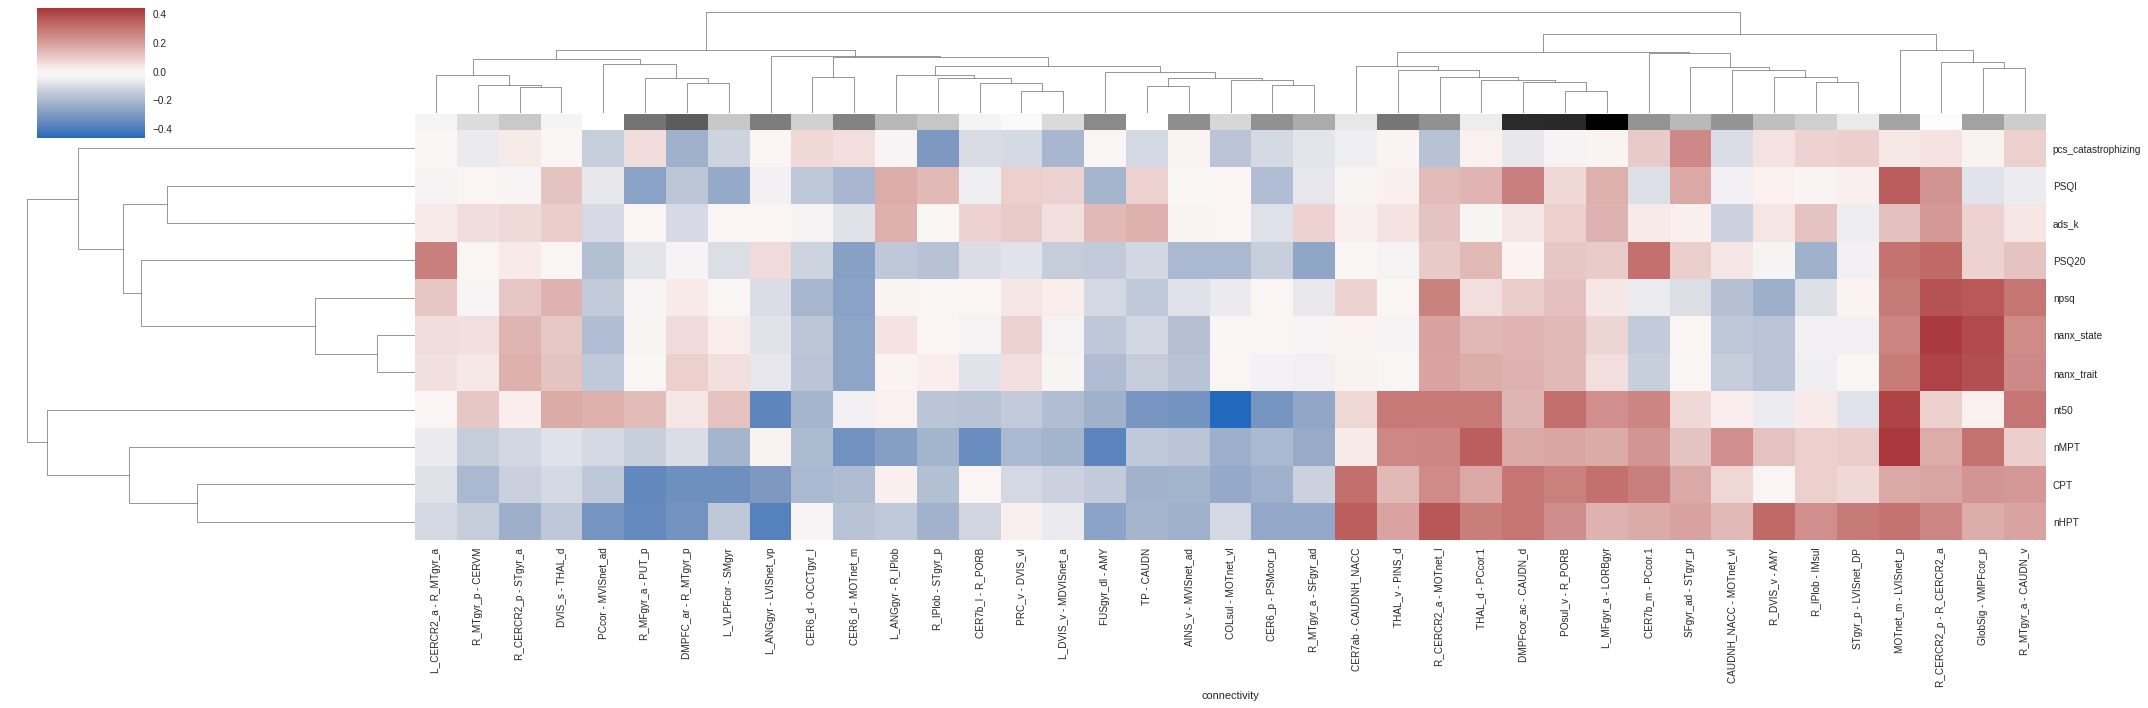

In [357]:
norm = Normalize()
fig = sns.clustermap(corrmtx.dropna(), method='average', cmap="vlag", figsize=(30,10), col_colors=cm.binary(norm(mc_model['abs_multi-center'])))

In [358]:
fig.savefig('../res/multi-center/cluster_map.pdf')

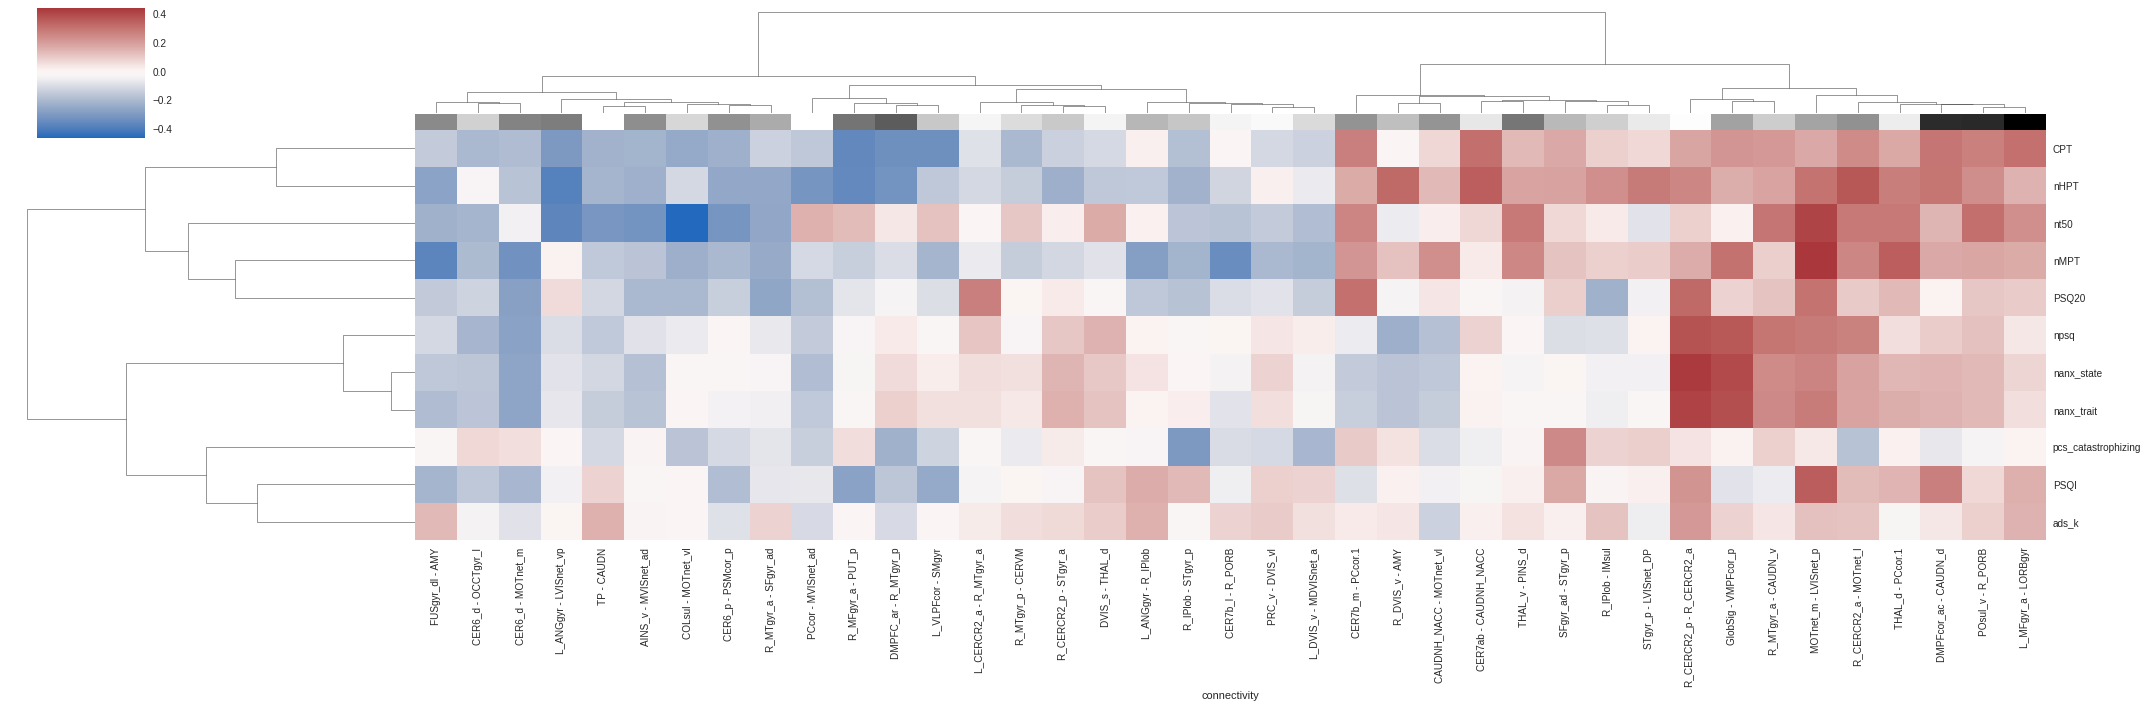

In [359]:
norm = Normalize()
fig = sns.clustermap(corrmtx.dropna(), method='ward', cmap="vlag", figsize=(30,10), col_colors=cm.binary(norm(mc_model['abs_multi-center'])))

In [360]:
fig.savefig('../res/multi-center/cluster_map2.pdf')

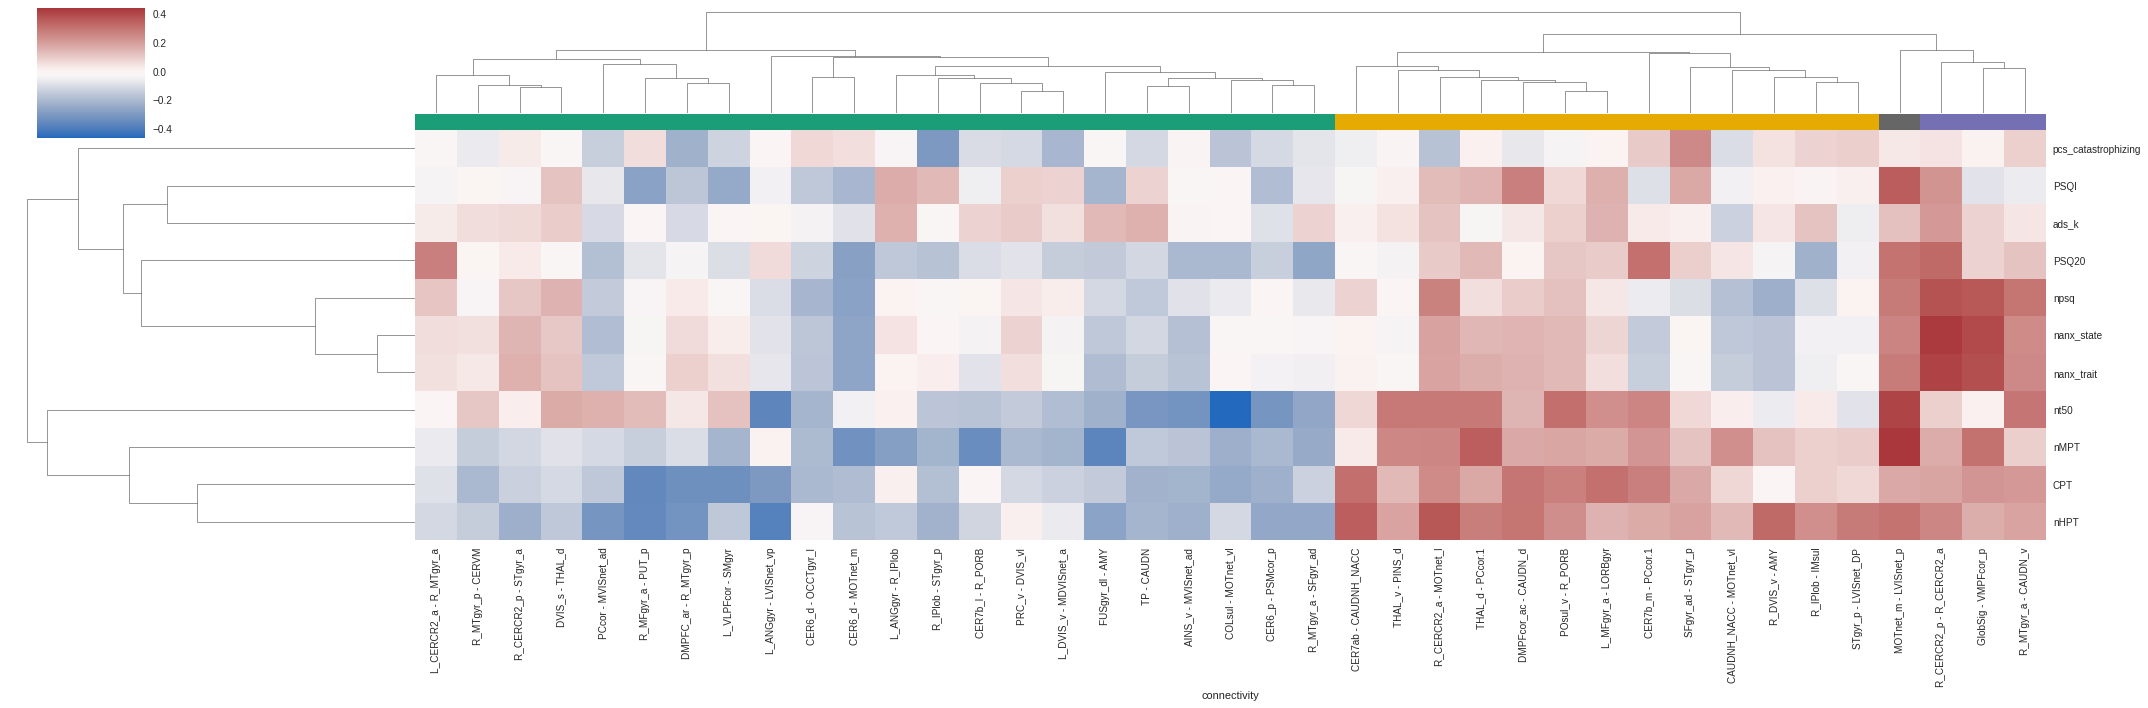

In [361]:
from sklearn.cluster import AgglomerativeClustering, KMeans
norm = Normalize()
fig = sns.clustermap(corrmtx.dropna(), method='average', metric='euclidean', cmap="vlag", figsize=(30,10), col_colors=cm.Dark2(norm(AgglomerativeClustering(n_clusters=4, linkage="average", affinity='euclidean').fit(corrmtx.dropna().T).labels_)))

In [362]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

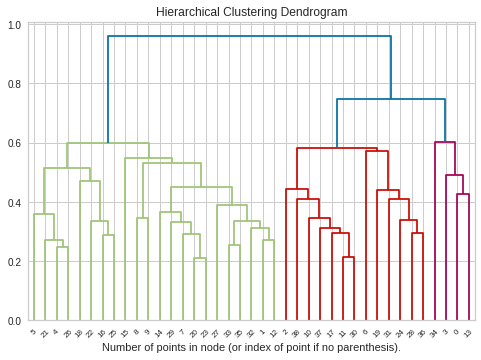

In [363]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(corrmtx.T)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, color_threshold=0.63)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


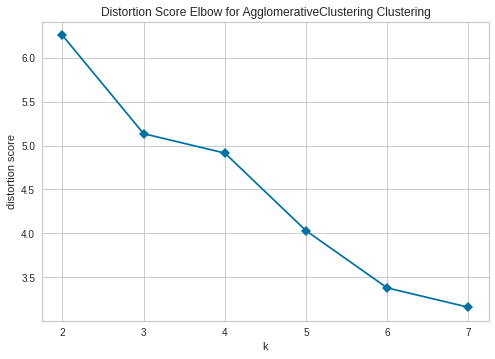

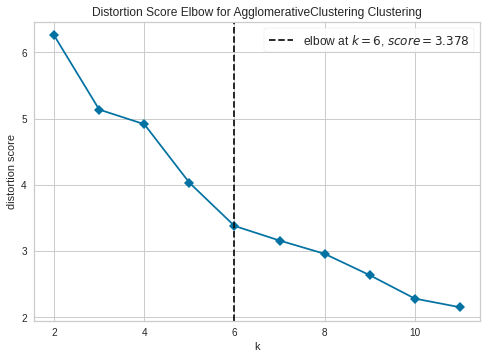

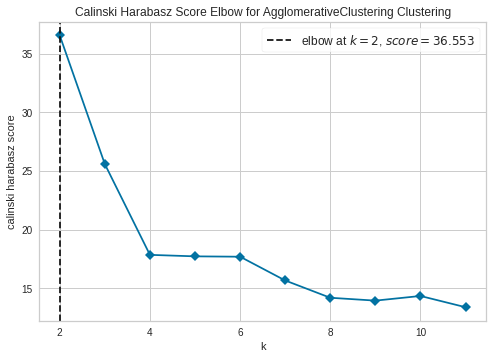

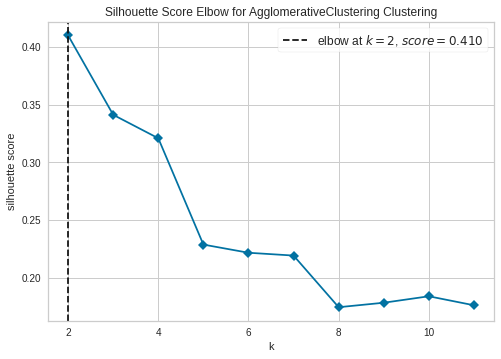

<AxesSubplot:title={'center':'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [381]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering(linkage='average', affinity='euclidean')
# k is range of number of clusters.
kmax = 12 #corrmtx.shape[1]

visualizer = KElbowVisualizer(model, k=(2,8), timings= False) # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False) # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False, metric='calinski_harabasz') # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False, metric='silhouette') # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()

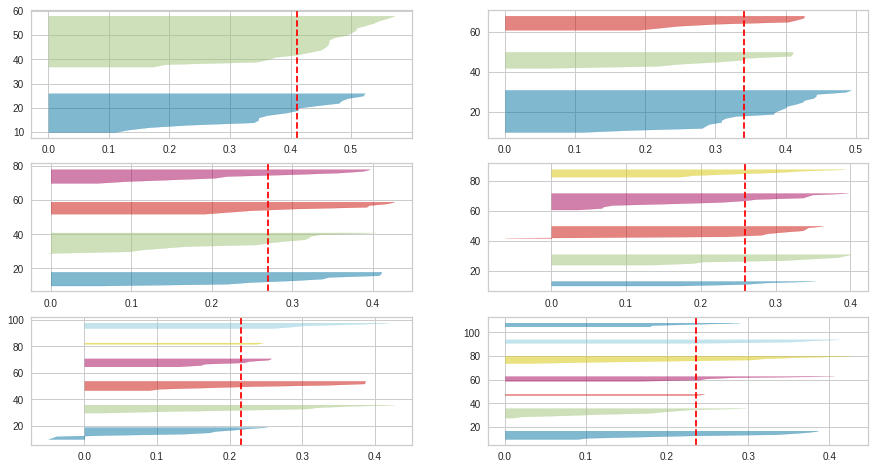

In [377]:
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer


fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=None)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(corrmtx.T)

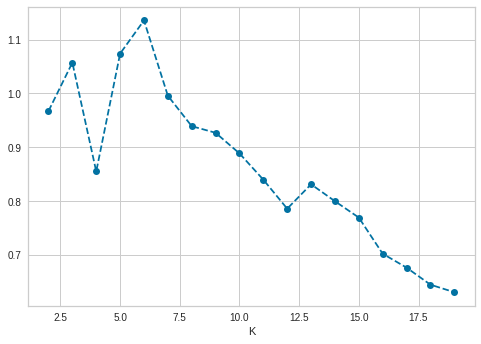

In [375]:
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = AgglomerativeClustering(n_clusters=center, linkage='average', affinity='euclidean')# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)

    # Calculate Davies Bouldin scorescore = davies_bouldin_score(cluster_df, model)
    score = davies_bouldin_score(data, model)

    return score

scores = []

centers = list(range(2,20))
for center in centers:
    scores.append(get_kmeans_score(corrmtx.T, center))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');